# SOEP Mortality Results for JOHM 2019

Authors: Lars Kroll, Jens Hoebel, Thomas Lampert

Stand: 12.10.2018

Version: 1.0


In [1]:
# Path
setwd("~/wissdaten/Abt2_Computation/P3_Mortality")
#setwd("~/Desktop/P3_Mortality")

# SCRATCH_DIR
scratch <- "~/SCRATCH_NOBAK/"
# scratch <- "data/" # home



# Libraries

In [2]:
# Attach libraries
library("tidyverse")
library("broom")
library("stringr")
library("survival")
library("rkicolors") # install_github("lekroll/rkicolors")
library("haven")
library("ggplot2")
library("wec")
library("ggfortify")
library("srvyr")
library("survey")
library("foreach")
library("doMC")
library("openxlsx")

# Jupyter Set-up
options(repr.plot.width=6, repr.plot.height=(6/16)*9 , repr.plot.dpi=300)
options(jupyter.plot_mimetypes = c("text/plain", "image/png" ))

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘srvyr’

The following object is masked from ‘package:stats’:

    filter

Loading required package: grid
Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand


Attaching package: ‘survey’

The following object is masked from ‘package:graphics’:

    dotchart


Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loading required package: iterators
Loading required package: parallel


# Data Management
We use data from GSOEP which can be obtained [here](https://www.diw.de/en/diw_02.c.222518.en/research_data_center_of_the_soep.html) as well as annual death rates based on the official German Life Tables which can be obtained from the [Federal Statistical Office for Germany](www.destatis.de).

## SOEP


### Load SOEP Data
We used the long format of SOEP and performed custom computations and matching of multiple long format files. The Methods of the data matching and creation of our working dataset called *"soep_arbeitsdaten.dta"* cannot be described in detail here. 

In [3]:
# Load recoded SOEP data
dir.create(paste0(scratch,"v33"), showWarnings =FALSE)
file.copy("data/v33/soep_trend_full.dta",paste0(scratch,"v33/soep_trend_full.dta"),overwrite=F)
file.copy("data/v33/soep_arbeitsdaten.dta",paste0(scratch,"v33/soep_arbeitsdaten.dta"),overwrite=F)

soep <- read_dta(paste0(scratch,"v33/soep_arbeitsdaten.dta"))

soep.rec <- soep %>% ungroup() %>%
    select(pid,hid,cid,sex,age,year=syear,
           todjahr,todinfo,contains("hrf"),
           SDeqinc,SDincpos,SDcasmin) %>%
mutate(
    gebjahr=year-age,
    SDincpos_grp = ifelse(SDincpos<0.60, "<60%",NA),
    SDincpos_grp = ifelse(SDincpos>=0.60 & SDincpos<0.80," 60%-79%",SDincpos_grp),
    SDincpos_grp = ifelse(SDincpos>=0.80 & SDincpos<1.00, " 80%-99%",SDincpos_grp),
    SDincpos_grp = ifelse(SDincpos>=1.00 & SDincpos<1.50, "100%-149%",SDincpos_grp),
    SDincpos_grp = ifelse(SDincpos>=1.50, "150% u.m.",SDincpos_grp),
    SDincpos_grp = factor(SDincpos_grp, levels=c("<60%"," 60%-79%"," 80%-99%","100%-149%","150% u.m.")),
    sex=ifelse(sex==1,"M","W"),
    SDcasmin=as_factor(SDcasmin)) %>%
rename("incpos"=SDincpos_grp)

andata <- soep.rec %>% filter(year>=1992) %>%
    group_by(pid) %>% arrange(pid,year) %>%
    mutate(
        SurvJahr=ifelse(is.na(todjahr),max(year),todjahr),
        SurvTime=ifelse(is.na(todjahr),max(age),todjahr-gebjahr),
        death=ifelse(is.na(todjahr),0,1)) %>% ungroup()

[1] FALSE

[1] FALSE

### Show Properties of our Dataset

Episodes
617550


Respondents
83287


Deaths
4193


Warning message:
“Column `year` has different attributes on LHS and RHS of join”

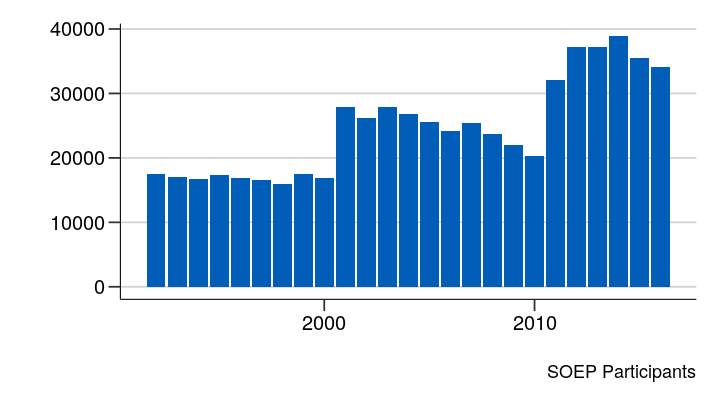

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

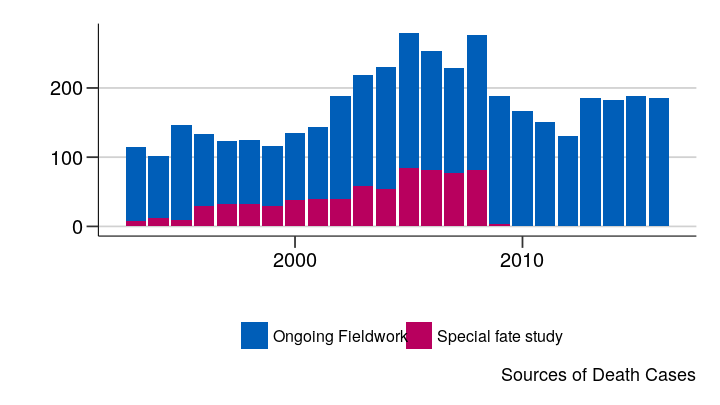

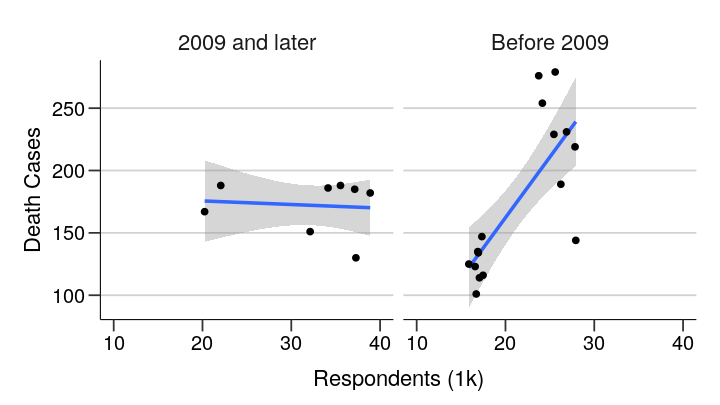

In [4]:
andata %>% summarise(Episodes=n())
as_tibble(andata) %>% group_by(pid) %>% filter(row_number()==1) %>% ungroup()  %>% summarise("Respondents"=n())
as_tibble(andata) %>% group_by(pid) %>% filter(row_number()==1) %>% ungroup() %>% filter(!is.na(todjahr)) %>% as_tibble() %>% summarise("Deaths"=n())

plotdata <- left_join(andata %>% filter(tsphrf>0) %>% group_by(year) %>% summarise(Respondents=n(), Mean_Age =mean(age, na.rm=T)) ,
andata %>% group_by(pid) %>% filter(row_number()==1)  %>% mutate(todinfo=as_factor(todinfo))  %>% filter(!is.na(todjahr)) %>% group_by(todjahr) %>% count() %>% ungroup() %>% rename(year=todjahr,Deaths=n) , by="year")

# Plot Respondents
plot.soep.respondents <- ggplot(plotdata,aes(x=year,y=Respondents, fill="x")) + geom_bar(stat="identity") + theme_rki() +
scale_fill_rki("qualitative") + labs(fill="",y="",caption="SOEP Participants",x="") + guides(fill=FALSE) +
theme(legend.position="bottom") 

# Plot Deaths
plot.soep.deaths <- andata %>% group_by(pid) %>% filter(row_number()==1) %>% mutate(info= case_when(todinfo %in% c(5,6,7) ~ "Special fate study",
                                            todinfo %in% c(1,2,3,4,8) ~ "Ongoing Fieldwork"))  %>% filter(!is.na(todjahr)) %>% group_by(todjahr,info) %>% count() %>% ungroup() %>%
ggplot(.,aes(x=todjahr,y=n, fill=info)) + 
geom_bar(stat="identity") + theme_rki() + scale_fill_rki("qualitative") + labs(fill="",y="",caption="Sources of Death Cases",x="") +
theme(legend.position="bottom") 

# Plot Comparison with and without fate studies
plot.soep.deathrates <- ggplot(plotdata, aes(y=Deaths,x=Respondents/1000)) + geom_smooth(method="gam") + geom_point() + 
facet_grid(. ~ ifelse(year<2009,"Before 2009","2009 and later")) + theme_rki() + scale_fill_rki() + scale_color_rki() +
labs(x="Respondents (1k)", y="Death Cases") + scale_x_continuous(limits=c(10,40))

# Write Info to Excel
write.xlsx(plotdata, file = "Results_Mortality.xlsx", sheetName="SOEP")

# Write Plots to Excel
wb <- loadWorkbook("Results_Mortality.xlsx")
plot.soep.respondents
insertPlot(wb, "SOEP", width = 7.11, height = 4, startRow = 1,  startCol = 6  , fileType = "png", units = "in", dpi = 400)
plot.soep.deaths
insertPlot(wb, "SOEP", width = 7.11, height = 4, startRow = 1,  startCol = 18  , fileType = "png", units = "in", dpi = 400)
plot.soep.deathrates
insertPlot(wb, "SOEP", width = 7.11, height = 4, startRow = 22,  startCol = 6  , fileType = "png", units = "in", dpi = 400)
saveWorkbook(wb, "Results_Mortality.xlsx" , overwrite=TRUE)


### Conclusion

Estimates for deaths after 2009 are quite unreliable, due to a large number of censored cases with unknown whereabouts as a consequence of missing fate/whereabout data on nonrespondents.

## Life Tables

In [5]:
# load data
load("data/destatis/life_tables_brd.RData")
#lifetables.metadata
#head(lifetables.data)

# recode data
lifetables.rec <- lifetables.data %>% filter(DINSG=="DG") %>% 
    select(sex=GES,year=JAHR,age=ALT577,qx=LEB001_val,LE_orig=LEB007_val) %>%
    mutate(sex=as.character(str_sub(sex, 4, -1)),
           age=as.numeric(str_sub(age, 8, -1)))  %>%
           group_by(sex,year) %>% mutate(qx=ifelse(age==last(age) & qx==last(qx) & last(qx)==0,NA,qx))
# Give all Years the same age range
lifetables.rec <- lifetables.rec %>% group_by(sex,year) %>% arrange(sex,year,age) %>%
mutate(qx=ifelse(age==last(age) & qx==0, NA,qx),lastage=max(age)) %>%
left_join(expand.grid("sex"=unique(lifetables.rec$sex),"year"=unique(lifetables.rec$year),"age"=seq(0:112)) %>% arrange(year,sex,age) %>% mutate(sex=as.character(sex)),.
          , by=c("sex","year","age")) %>%  group_by(sex,year) %>% 
mutate(lastage=max(lastage,na.rm=T),qx=ifelse(is.na(qx),max(qx, na.rm=T)*1.06^(age-lastage-1),qx)) %>% select(-lastage) %>% mutate(age=age-1)

Adding missing grouping variables: `year`
Joining, by = c("sex", "year", "age")
Joining, by = c("sex", "year", "age", "qx", "LE_orig")


sex,Mean_Diff
M,0.03827063
W,-0.01934891


`geom_smooth()` using method = 'loess'


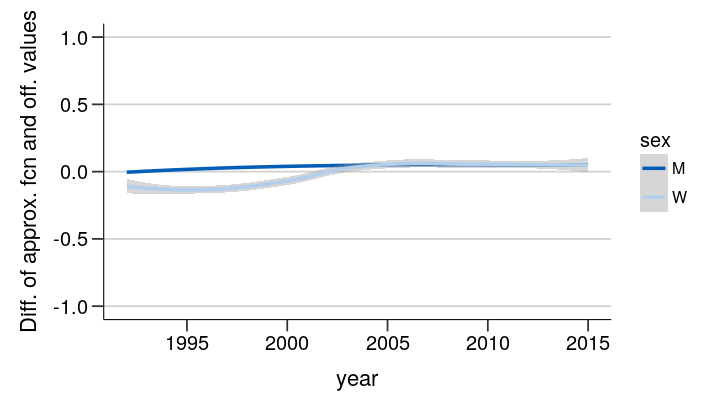

In [6]:
# Function to calculate life expactancies from death rates.
life_expectancy <- function(data,deathrate="qx",age="age",indicator="ex_t"){
   tempdata <- data %>%  rename("deathrate"=deathrate,"age"=age)  %>% group_by(age, add=T) %>% summarise(deathrate=mean(deathrate))
   group_vars <- setdiff(names(tempdata) ,c("age","deathrate")) 
   tempdata %>% group_by_at(group_vars) %>%
   mutate(S_t = ifelse(age==0,1,NA),
           S_t = ifelse(age>0,1-lag(deathrate),S_t),
           S_t = cumprod(S_t),
           H_t = 1-S_t,                 
           ex_t= cumsum(S_t),
           ex_t= last(ex_t)-ex_t+.45) %>% select(-deathrate)   %>%     
    select_(group_vars,age,indicator) %>% left_join(data,.)
}
le.comparison.methods <- left_join(lifetables.rec,lifetables.rec %>% group_by(sex,year) %>% life_expectancy(.)) %>% 
    rename(LE_function = ex_t) %>% filter(age==0) %>% 
    mutate(Difference=LE_orig-LE_function) 
le.comparison.methods %>% group_by(sex) %>% summarise(Mean_Diff = mean(Difference))
ggplot(le.comparison.methods ,aes(x=year,color=sex,y=Difference)) + geom_smooth() + theme_rki() + scale_color_rki() + scale_y_continuous(limits=c(-1,1)) + labs(y="Diff. of approx. fcn and off. values")

The Function to compute life expectancies based on age specific death rates (`life_expectancy()`) produces a high accuracy when compared to the calculations that were provided by DESTATIS (via Indcicator `LEB006`). We conclude that it can be used to approximate group specific life expectancies.

# Analysis

The analytical strategy was first outlined by Kroll, Lampert (2009) [PDF](https://www.gesis.org/fileadmin/upload/forschung/publikationen/zeitschriften/mda/Vol.3_Heft_1/02_Kroll.pdf) and is slightly modified for the current analysis. We will analyse the data in the following steps: 
1. Analyse the Inequalities in Mortality using an Indicator for the current Income Position in SOEP for two age groups (0-50,51-101) using Cox Proportional Hazard Regression models (function `svycoxph` from package `survey`).
2. Apply the resulting Hazard Ratios as well as their upper and lower confidence bands in effect coding ([cf. source](https://rstudio-pubs-static.s3.amazonaws.com/65059_586f394d8eb84f84b1baaf56ffb6b47f.html)) to death rates from official life tables.
3. Calculate life expectancies based on calculated rates including CI

## Functions

In [7]:
# Create Groups for Analysis
create_angroups <- function (data,seqyear=3,seqage=51)
{
# Sex
sex <-  c("M","W")
# Time
startyear <-min(data$year)
stopyear <- max(data$year)-1 # tbd dynamically
# Age
startage <- 0
stopage <- 100 
# Define Groups
startyear <-seq(startyear,stopyear,seqyear)
startage<-seq(startage,stopage,seqage)
angroups <- expand.grid(sex=sex,begin=startyear,youngest=startage) %>%   
arrange(sex,begin,youngest)  %>% 
mutate(
  group_number=1:n(),  
  sex=as.character(sex)  ,
  end=begin+seqyear-1,
  oldest=youngest+seqage-1) %>%
  select(group_number,sex,begin,end,youngest,oldest) 
print(paste("Number of Groups to analyze:",nrow(angroups)))
angroups
}

# Merge Effects and Lifetable Data
merge_lifetable <- function (myResult,groupdefs) {
    lifetables.rec %>% filter(sex==groupdefs$sex   &
                      year>=groupdefs$begin & 
                      year<=groupdefs$end &
                      age>=groupdefs$youngest &
                      age<=groupdefs$oldest) %>%
    mutate(begin=groupdefs$begin,end=groupdefs$end) %>% group_by(sex,begin,end,age) %>% summarise(qx=mean(qx,na.rm=T)) %>% ungroup() %>% 
    left_join(groupdefs,.) %>%
    left_join(myResult,.,by=names(groupdefs)) %>%
    mutate(qx.base=qx,
           qx.low =qx*conf.low,
           qx.high=qx*conf.high,
           qx     =qx*estimate) 
}

# Predict LE 
predict_lifexp <- function (myResult) {
myResult %>% 
life_expectancy(.,deathrate="qx.base" ) %>% rename("LE_pop"=ex_t) %>% 
life_expectancy(.,deathrate="qx" ) %>% rename("LE_mean"=ex_t) %>% 
life_expectancy(.,deathrate="qx.low" ) %>% rename("LE_max"=ex_t)  %>% 
life_expectancy(.,deathrate="qx.high" ) %>% rename("LE_min"=ex_t) %>%
life_expectancy(.,deathrate="qx.base" , indicator="S_t") %>% rename("Surv_pop"=S_t) %>% 
life_expectancy(.,deathrate="qx" , indicator="S_t") %>% rename("Surv_mean"=S_t) %>% 
life_expectancy(.,deathrate="qx.low" , indicator="S_t" ) %>% rename("Surv_max"=S_t)  %>% 
life_expectancy(.,deathrate="qx.high" , indicator="S_t" ) %>% rename("Surv_min"=S_t) 
    
}

# Filter data for Survival Analysis
filter_soep <- function (data,groupdefs) {
    data %>% 
    filter(sex==groupdefs$sex &
           year>=groupdefs$begin & 
           year<=groupdefs$end & 
           age>=groupdefs$youngest &
           age<=groupdefs$oldest) %>% 
    group_by(pid) %>% mutate(tsphrf=mean(tsphrf,na.rm=T)) %>% filter(row_number()==1) %>% 
    ungroup()    %>% as_survey_design(ids = pid, weight=tsphrf)
}
# Get Number of Cases and Observations depending on survival Status
cases_soep <-  function (data,groupdefs,determinant) {
    left_join(data$variables %>%
              group_by(pid) %>% filter(row_number()==1) %>% ungroup() %>% group_by_(determinant,"death") %>%
              summarise(Number = n()) %>% ungroup() %>% 
              mutate(death=ifelse(death==1,"Cases Death","Cases Censored")) %>% 
              spread(death,Number),
       data$variables %>% group_by_(determinant)  %>% summarise(Episodes = n()), 
        by=c(determinant)) %>% 
    rename("label"=determinant) %>% filter(!is.na(label)) %>% cbind(groupdefs,., row.names = NULL) %>% mutate(label=as.character(label))
}

# Get Hazard Ratios from Survival Model
survival_reg_soep <- function(data,groupdefs,determinant,controls) {
    contrasts(data$variables[[determinant]]) <- "contr.sum"
    Survdef <- "Surv(SurvTime, death, type=\"right\")"
    formula <- as.formula(paste(Survdef, paste(determinant,"+",paste(controls, collapse=" + ")), sep=" ~ ")) 
    data  %>% svycoxph(formula, data=. , design=.) %>%    broom::tidy(exponentiate=TRUE) 
}

# Use Effect Coding and provide Estimates in Reference to the Grand Mean for all Levels
survival_reg_soep_alllevels <- function(data,groupdefs,determinant,controls) {
    # Store original Labels
    myLabels <- cbind(term=determinant,label=levels(data$variables[[determinant]])) %>% 
              as_tibble() %>% 
              mutate(term=paste0(term,1:n()))    
    # Effect coding with standard Refernce Category
    data$variables[[determinant]] <- relevel(data$variables[[determinant]], ref=levels(data$variables[[determinant]])[1])
    myReg <- invisible(survival_reg_soep(data,groupdefs,determinant,controls))
    # Effect coding with alternative Reference Category
    data$variables[[determinant]] <- relevel(data$variables[[determinant]], ref=levels(data$variables[[determinant]])[length(levels(data$variables[[determinant]]))])
    myReg <- bind_rows(myReg,invisible(survival_reg_soep(data,groupdefs,determinant,controls)) %>%  # filter only last level and rename term accordingly
                      filter(term==paste0(determinant,1)) %>% 
                      mutate(term=paste0(determinant,length(levels(data$variables[[determinant]]))))
                      ) %>% arrange(term) 
    # Merge with label
    myReg <-  left_join(myReg,
              myLabels, by="term") %>% arrange(.,term,label) 
myReg
}

# Combine all Subfunctions
survival_soep <- function(data,groupdefs,determinant,controls,byvars) {
    # Group Summary
    myResult <- data.frame(groupdefs)
    # Data
    data <- filter_soep(data,groupdefs)
    # Case Summary
    myResult <- left_join(myResult,cases_soep(data,groupdefs,determinant),by=names(groupdefs))
    # Regression
    myReg <- survival_reg_soep_alllevels(data,groupdefs,determinant,controls)
    # Merge Effects
    myResult <- tryCatch(left_join(myResult,data.frame(myReg)), error=function (e) myResult)
    myResult                    
    }

# Gradient low vs. high
show_gradient <- function(result) {
result %>% select(group_number,sex,begin,end,youngest,oldest,label,estimate,p.value,contains("conf")) %>%
  group_by(group_number) %>%  filter(age==min(age)) %>% mutate_at(c("estimate","conf.low", "conf.high"), funs(./last(.))) %>% 
    mutate_at(c("estimate","conf.low", "conf.high","p.value"), funs(round(., digits = 4))) %>% filter(label=="<60%")
}
                         
# Show Difference low vs. high
show_lediff <- function(result,agefilter=0) {
    result %>% filter(age==agefilter ) %>%  group_by(sex,begin,end) %>% select(sex,begin,end,label,contains("LE_"))  %>%
arrange(sex,begin,label) %>% summarise(Diff_label=paste0(first(label)," vs. ",last(label)), 
                                      Diff = round(last(LE_mean)-first(LE_mean),digits=1),
                                      Diff_min= round(last(LE_min)-first(LE_max),digits=1),
                                      Diff_max= round(last(LE_max)-first(LE_min),digits=1))
}
                         
# Test Functions
#================
#andata$variables  %>% count(year) %>% arrange(-n) %>% head(.)
#andata$variables  %>% count(pid) %>% count(n) %>% head(.)
# filter_soep(andata,angroups[1,]) %>% head(.)
# survival_reg_soep_alllevels(filter_soep(andata,angroups[1,]),angroups[1,],"incpos","age")
# survival_soep(andata,angroups[1,],"incpos","age")
# survival_soep(andata,angroups[1,],"incpos","age") %>% merge_lifetable(.,angroups[1,]) %>% head(10)

## Result

In [8]:
# Set and show analysis Groups
angroups_all <- create_angroups(andata,seqyear=25)
angroups_all
angroups <- create_angroups(andata,seqyear=4)
angroups

[1] "Number of Groups to analyze: 4"


group_number,sex,begin,end,youngest,oldest
1,M,1992,2016,0,50
2,M,1992,2016,51,101
3,W,1992,2016,0,50
4,W,1992,2016,51,101


[1] "Number of Groups to analyze: 24"


group_number,sex,begin,end,youngest,oldest
1,M,1992,1995,0,50
2,M,1992,1995,51,101
3,M,1996,1999,0,50
4,M,1996,1999,51,101
5,M,2000,2003,0,50
6,M,2000,2003,51,101
7,M,2004,2007,0,50
8,M,2004,2007,51,101
9,M,2008,2011,0,50
10,M,2008,2011,51,101


In [9]:
lifetables.rec %>% filter(year>=1992 & year<=2016) %>% group_by(sex,age)  %>% summarise(qx=mean(qx,na.rm=T)) %>% group_by(sex) %>% life_expectancy(.) %>% filter(age==0 | age==65) %>% select(-qx) %>% spread(age,ex_t)

Joining, by = c("sex", "age")


sex,0,65
M,75.05118,12.52935
W,80.76696,17.04319


### Computation

In [10]:
# Model for all Angroups
#######################
registerDoMC(2)
anresult <- invisible(foreach(i=1:nrow(angroups)) %do% { # nrow(angroups)
    myresult <- survival_soep(data=andata,groupdefs=angroups[i,],determinant="incpos",controls=c("age"),byvars="sex") %>%
    merge_lifetable(.,angroups[i,])
    myresult
    })

# Store Result
anresult <- plyr::rbind.fill(anresult) %>% 
         filter(stringr::str_detect(term,"incpos")) %>% mutate(label = ordered(label,levels=levels(andata$incpos))) 

# Predict Lifeexpectancy
anresult.le <- anresult %>% group_by(sex, begin, label) %>% arrange(sex, begin, label , age) %>%  predict_lifexp(.) 

# Overall Result 
#######################
overallresult <- invisible(foreach(i=1:nrow(angroups_all)) %do% { 
    myresult <- survival_soep(data=andata,groupdefs=angroups_all[i,],determinant="incpos",controls=c("age"),byvars="sex") %>%
    merge_lifetable(.,angroups_all[i,])
    myresult
    })
registerDoMC(1) # Register 1 Core to reduce System load

# Store Result
overallresult <- plyr::rbind.fill(overallresult) %>% 
         filter(stringr::str_detect(term,"incpos")) %>% mutate(label = ordered(label,levels=levels(andata$incpos))) 

# Predict Lifeexpectancy
overallresult.le <- overallresult %>% group_by(sex, begin, label) %>% arrange(sex, begin, label , age) %>%  predict_lifexp(.)


Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf
Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf


Joining, by = "label"
Joining, by = c("sex", "begin", "end")


Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf
Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf


Joining, by = "label"
Joining, by = c("sex", "begin", "end")


Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf
Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf


Joining, by = "label"
Joining, by = c("sex", "begin", "end")


Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf
Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf


Joining, by = "label"
Joining, by = c("sex", "begin", "end")


Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf
Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf


Joining, by = "label"
Joining, by = c("sex", "begin", "end")


Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf
Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf


Joining, by = "label"
Joining, by = c("sex", "begin", "end")


Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf
Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf


Joining, by = "label"
Joining, by = c("sex", "begin", "end")


Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf
Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf


Joining, by = "label"
Joining, by = c("sex", "begin", "end")


Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf
Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf


Joining, by = "label"
Joining, by = c("sex", "begin", "end")


Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf
Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf


Joining, by = "label"
Joining, by = c("sex", "begin", "end")


Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf
Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf


Joining, by = "label"
Joining, by = c("sex", "begin", "end")


Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf
Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf


Joining, by = "label"
Joining, by = c("sex", "begin", "end")


Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf
Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf


Joining, by = "label"
Joining, by = c("sex", "begin", "end")


Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf
Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf


Joining, by = "label"
Joining, by = c("sex", "begin", "end")


Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf
Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf


Joining, by = "label"
Joining, by = c("sex", "begin", "end")


Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf
Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf


Joining, by = "label"
Joining, by = c("sex", "begin", "end")


Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf
Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf


Joining, by = "label"
Joining, by = c("sex", "begin", "end")


Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf
Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf


Joining, by = "label"
Joining, by = c("sex", "begin", "end")


Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf
Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf


Joining, by = "label"
Joining, by = c("sex", "begin", "end")


Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf
Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf


Joining, by = "label"
Joining, by = c("sex", "begin", "end")


Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf
Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf


Joining, by = "label"
Joining, by = c("sex", "begin", "end")


Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf
Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf


Joining, by = "label"
Joining, by = c("sex", "begin", "end")


Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf
Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf


Joining, by = "label"
Joining, by = c("sex", "begin", "end")


Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf
Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf


Joining, by = "label"
Joining, by = c("sex", "begin", "end")
Adding missing grouping variables: `begin`, `label`
Joining, by = c("sex", "begin", "label", "age")
Adding missing grouping variables: `begin`, `label`
Joining, by = c("sex", "begin", "label", "age")
Adding missing grouping variables: `begin`, `label`
Joining, by = c("sex", "begin", "label", "age")
Adding missing grouping variables: `begin`, `label`
Joining, by = c("sex", "begin", "label", "age")
Adding missing grouping variables: `begin`, `label`
Joining, by = c("sex", "begin", "label", "age")
Adding missing grouping variables: `begin`, `label`
Joining, by = c("sex", "begin", "label", "age")
Adding missing grouping variables: `begin`, `label`
Joining, by = c("sex", "begin", "label", "age")
Adding missing grouping variables: `begin`, `label`
Joining, by = c("sex", "begin", "label", "age")


Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf
Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf


Joining, by = "label"
Joining, by = c("sex", "begin", "end")


Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf
Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf


Joining, by = "label"
Joining, by = c("sex", "begin", "end")


Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf
Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf


Joining, by = "label"
Joining, by = c("sex", "begin", "end")


Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf
Independent Sampling design (with replacement)
Called via srvyr
Sampling variables:
 - ids: pid
 - weights: tsphrf


Joining, by = "label"
Joining, by = c("sex", "begin", "end")
Adding missing grouping variables: `begin`, `label`
Joining, by = c("sex", "begin", "label", "age")
Adding missing grouping variables: `begin`, `label`
Joining, by = c("sex", "begin", "label", "age")
Adding missing grouping variables: `begin`, `label`
Joining, by = c("sex", "begin", "label", "age")
Adding missing grouping variables: `begin`, `label`
Joining, by = c("sex", "begin", "label", "age")
Adding missing grouping variables: `begin`, `label`
Joining, by = c("sex", "begin", "label", "age")
Adding missing grouping variables: `begin`, `label`
Joining, by = c("sex", "begin", "label", "age")
Adding missing grouping variables: `begin`, `label`
Joining, by = c("sex", "begin", "label", "age")
Adding missing grouping variables: `begin`, `label`
Joining, by = c("sex", "begin", "label", "age")


### Overall Results for the whole observational period

sex,begin,end,Diff_label,Diff,Diff_min,Diff_max,Outcome
M,1992,2016,<60% vs. 150% u.m.,8.6,5.0,12.4,LE at birth
W,1992,2016,<60% vs. 150% u.m.,4.4,1.2,7.8,LE at birth
M,1992,2016,<60% vs. 150% u.m.,6.6,4.1,9.0,LE at 65 yrs
W,1992,2016,<60% vs. 150% u.m.,3.7,1.2,6.2,LE at 65 yrs


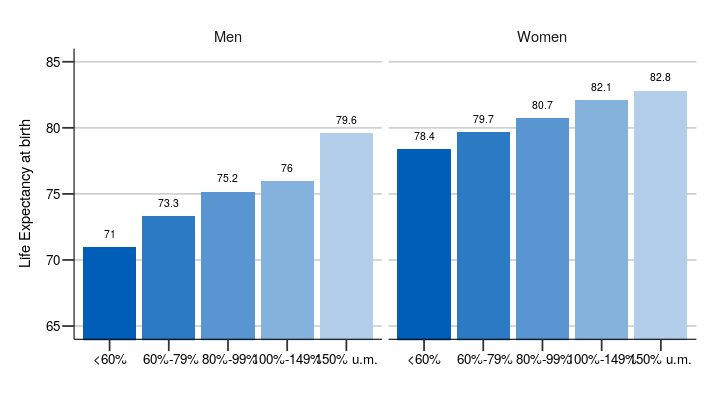

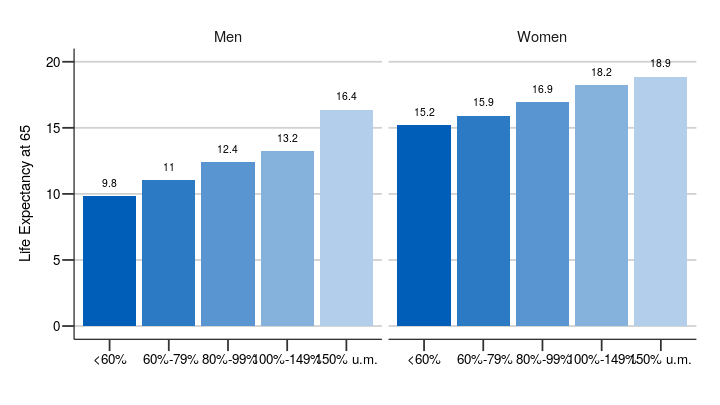

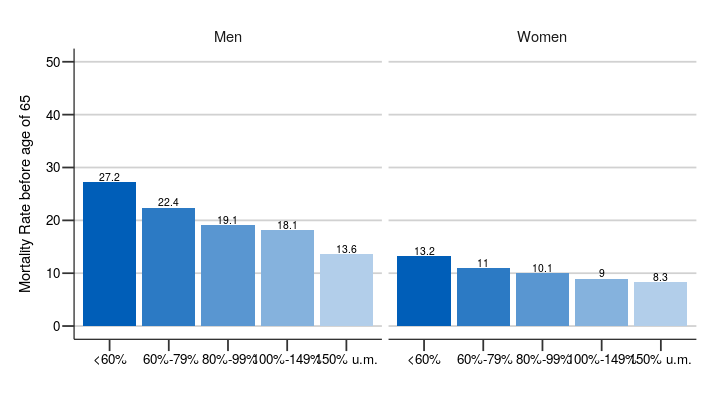

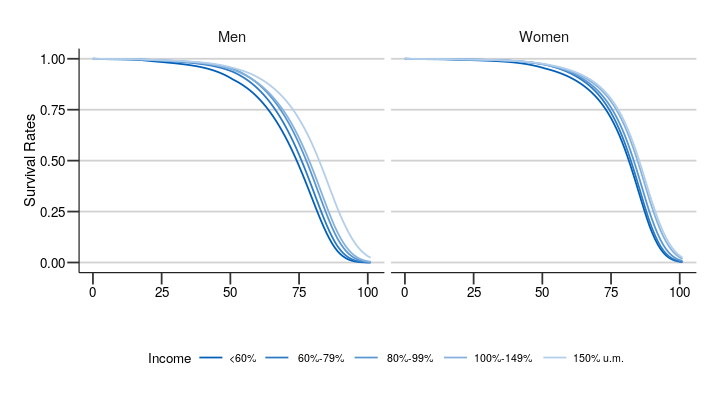

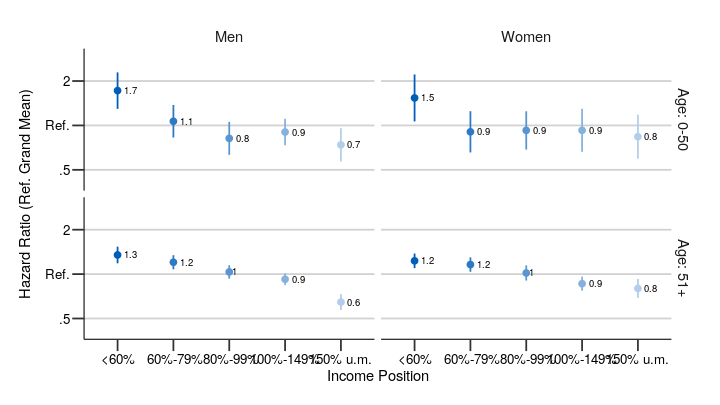

In [11]:
myresult <- bind_rows(overallresult.le  %>% show_lediff(.,agefilter=0) %>% mutate(Outcome="LE at birth") ,
          overallresult.le  %>% show_lediff(.,agefilter=65)%>% mutate(Outcome="LE at 65 yrs") )
wb <- loadWorkbook("Results_Mortality.xlsx")
addWorksheet(wb, "Overall")
writeDataTable(wb, "Overall", myresult)
addWorksheet(wb, "Overall (Raw)")
writeDataTable(wb, "Overall (Raw)", overallresult.le)
myresult

# Plot LE at birth
le_plot_all <- overallresult.le %>% filter(age==0) %>% 
select(begin,end,sex,label,contains("LE_")) %>% ungroup() %>%
mutate(sex=ifelse(sex=="M","Men","Women"),
       sex=ordered(sex,levels=c("Men","Women"))) %>%  
       ggplot(.,aes(x=label,y=LE_mean, label=round(LE_mean, digits=1), fill=label)) +  facet_grid(.~sex) + theme_rki(base_size=8) + scale_fill_rki(reverse=F) +
labs(x="",y="Life Expectancy at birth", fill="Income")   + geom_bar(stat="identity") + coord_cartesian(ylim=c(65,85)) +
geom_text(aes(y=LE_mean+1), size=2.2) + guides(fill=FALSE)
le_plot_all
insertPlot(wb, "Overall", width = 7.11, height = 4, startRow = 1,  startCol = length(myresult)+5 , fileType = "png", units = "in", dpi = 400)

# Plot LE at 65
le65_plot_all <- overallresult.le %>% filter(age==65) %>% 
select(begin,end,sex,label,contains("LE_")) %>% ungroup() %>%
mutate(sex=ifelse(sex=="M","Men","Women"),
       sex=ordered(sex,levels=c("Men","Women"))) %>%  
       ggplot(.,aes(x=label,y=LE_mean, label=round(LE_mean, digits=1), fill=label)) +  facet_grid(.~sex) + theme_rki(base_size=8) + scale_fill_rki(reverse=F) +
labs(x="",y="Life Expectancy at 65", fill="Income")   + geom_bar(stat="identity") + coord_cartesian(ylim=c(0,20)) +
geom_text(aes(y=LE_mean+1), size=2.2) + guides(fill=FALSE)
le65_plot_all
insertPlot(wb, "Overall", width = 7.11, height = 4, startRow = 22,  startCol = length(myresult)+5 , fileType = "png", units = "in", dpi = 400)


# Rates at 65
surv65_plot_all <- overallresult.le %>% filter(age==65) %>% 
select(begin,end,sex,label,contains("Surv_")) %>% ungroup() %>%
mutate(Surv_mean=(1-Surv_mean)*100,
       sex=ifelse(sex=="M","Men","Women"),
       sex=ordered(sex,levels=c("Men","Women"))) %>%
       ggplot(.,aes(x=label,y=Surv_mean, label=round(Surv_mean, digits=1), fill=label)) +  facet_grid(.~sex) + theme_rki(base_size=8) + scale_fill_rki(reverse=F) +
labs(x="",y="Mortality Rate before age of 65", fill="Income")   + geom_bar(stat="identity")  + coord_cartesian(ylim=c(0,50)) +
geom_text(aes(y=Surv_mean+1), size=2.2) + guides(fill=FALSE)
surv65_plot_all
insertPlot(wb, "Overall", width = 7.11, height = 4, startRow = 7,  startCol = 1 , fileType = "png", units = "in", dpi = 400)

# Survival Rates
surv_rate_plot_all <- overallresult.le %>%  
select(begin,end,sex,age,label,contains("Surv_")) %>% ungroup() %>%
mutate(sex=ifelse(sex=="M","Men","Women"),
       sex=ordered(sex,levels=c("Men","Women"))) %>%  
       ggplot(.,aes(x=age,y=Surv_mean, label=round(Surv_mean, digits=1), color=label)) +  facet_grid(.~sex) + theme_rki(base_size=8) + scale_color_rki(reverse=F) +
labs(x="",y="Survival Rates", color="Income")  +
geom_line() + theme(legend.position="bottom")
surv_rate_plot_all
insertPlot(wb, "Overall", width = 7.11, height = 4, startRow = 27,  startCol = 1  , fileType = "png", units = "in", dpi = 400)

# Effects
effect_plot <- overallresult.le %>% select(sex,begin,end,label,youngest,oldest,estimate,contains("conf.")) %>% 
group_by(sex,begin,end,label,estimate,conf.low,conf.high) %>% filter(row_number()==1) %>% ungroup() %>%
mutate(Range=ifelse(oldest<max(oldest),paste0("Age: ",youngest,"-",oldest),paste0("Age: ",youngest,"+")),
      sex=ifelse(sex=="M","Men","Women")) %>%
ggplot(., aes(x=label,label=round(estimate,digits=1),y=estimate,ymin=conf.low,ymax=conf.high, color=label)) + geom_point() + geom_linerange()  +  facet_grid(Range~sex) +
 theme_rki(base_size=8) + scale_color_rki(reverse=F) + 
scale_y_log10(breaks=c(.5,1,2),labels=c(".5","Ref.","2"),limits=c(.4,3)) + theme(legend.position="bottom") + geom_text(color="black",size=2,hjust=-.5) +
labs(y="Hazard Ratio (Ref. Grand Mean)", x="Income Position") + guides(color=FALSE)
effect_plot
insertPlot(wb, "Overall", width = 7.11, height = 4, startRow = 42,   startCol = length(myresult)+5  , fileType = "png", units = "in", dpi = 400)
saveWorkbook(wb, "Results_Mortality.xlsx" , overwrite=TRUE)

### Results split by Timeframes four years

In [12]:
myresult <- bind_rows(anresult.le  %>% show_lediff(.,agefilter=0) %>% mutate(Outcome="LE at birth") ,
          anresult.le  %>% show_lediff(.,agefilter=65)%>% mutate(Outcome="LE at 65 yrs") )
wb <- loadWorkbook("Results_Mortality.xlsx")
addWorksheet(wb, "By Timeframe")
writeDataTable(wb, "By Timeframe", myresult)
addWorksheet(wb, "By Timeframe (Raw)")
writeDataTable(wb, "By Timeframe (Raw)", anresult.le)
myresult
saveWorkbook(wb, "Results_Mortality.xlsx" , overwrite=TRUE)

sex,begin,end,Diff_label,Diff,Diff_min,Diff_max,Outcome
M,1992,1995,<60% vs. 150% u.m.,9.2,4.3,14.3,LE at birth
M,1996,1999,<60% vs. 150% u.m.,10.5,4.3,17.1,LE at birth
M,2000,2003,<60% vs. 150% u.m.,6.4,0.7,12.1,LE at birth
M,2004,2007,<60% vs. 150% u.m.,11.2,4.5,18.2,LE at birth
M,2008,2011,<60% vs. 150% u.m.,9.0,0.6,18.3,LE at birth
M,2012,2015,<60% vs. 150% u.m.,11.9,1.2,20.3,LE at birth
W,1992,1995,<60% vs. 150% u.m.,4.6,0.2,9.2,LE at birth
W,1996,1999,<60% vs. 150% u.m.,3.3,-1.5,8.3,LE at birth
W,2000,2003,<60% vs. 150% u.m.,4.8,0.4,9.3,LE at birth
W,2004,2007,<60% vs. 150% u.m.,4.5,-1.7,11.1,LE at birth


#### Plots for Life Expectancy at birth

Joining, by = c("year", "sex")


year,sex,<60%,60%-79%,80%-99%,100%-149%,150% u.m.,begin,end,Diff_label,Diff,Diff_min,Diff_max
1994,Men,68.14727,70.06378,73.23286,72.78859,77.37307,1992,1995,<60% vs. 150% u.m.,9.2,4.3,14.3
1998,Men,69.37311,71.87188,72.12991,74.36616,79.90337,1996,1999,<60% vs. 150% u.m.,10.5,4.3,17.1
2002,Men,71.57333,73.40397,73.75882,76.63656,77.97920,2000,2003,<60% vs. 150% u.m.,6.4,0.7,12.1
2006,Men,69.43489,75.36592,75.03893,78.26047,80.58622,2004,2007,<60% vs. 150% u.m.,11.2,4.5,18.2
2010,Men,72.98021,72.71821,77.48447,78.18115,82.01307,2008,2011,<60% vs. 150% u.m.,9.0,0.6,18.3
2014,Men,72.35246,75.46192,75.87723,78.73051,84.24366,2012,2015,<60% vs. 150% u.m.,11.9,1.2,20.3
1994,Women,76.58993,77.62359,78.93736,79.80738,81.19369,1992,1995,<60% vs. 150% u.m.,4.6,0.2,9.2
1998,Women,78.10629,78.75766,79.12140,81.44502,81.39897,1996,1999,<60% vs. 150% u.m.,3.3,-1.5,8.3
2002,Women,78.24117,79.42081,80.45627,81.53351,83.06447,2000,2003,<60% vs. 150% u.m.,4.8,0.4,9.3
2006,Women,78.21777,81.12637,81.96006,82.11380,82.72687,2004,2007,<60% vs. 150% u.m.,4.5,-1.7,11.1


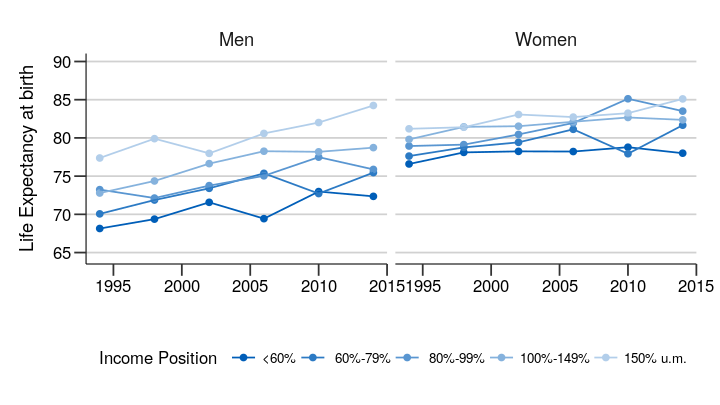

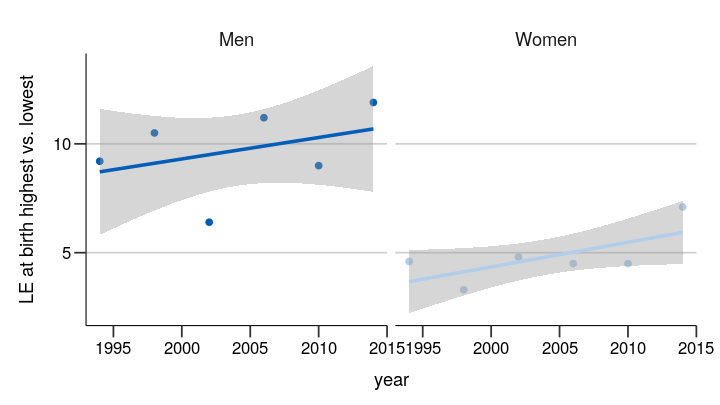

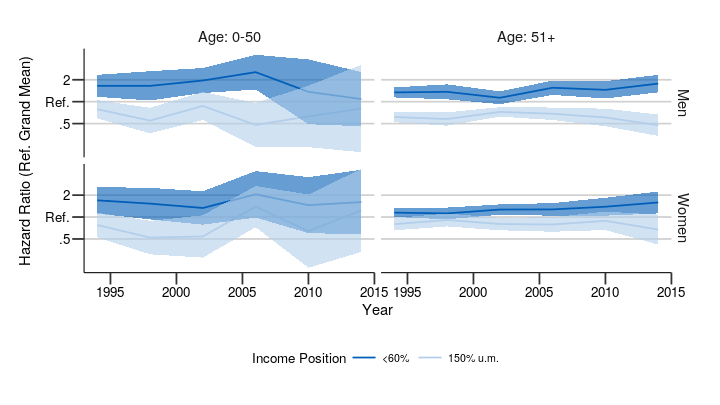

In [13]:
plotdata <- anresult.le %>% filter(age %in% c(0,65))  %>% select(sex,begin,end,age,label,contains("LE"),contains("Surv")) %>% ungroup() %>% 
            mutate(Geschlecht=ifelse(sex=="M","Men","Women"),
                  Geschlecht=ordered(Geschlecht,levels=c("Men","Women")),
                  Jahr=round((begin+end)/2)) %>% arrange(sex,begin,label) %>% 
            mutate_at(vars(contains("Surv")),funs(.*100))
plotdata_at_birth <- plotdata %>% filter(age==0) %>% select(label,year=Jahr,sex=Geschlecht,LE_mean) %>% spread(label,LE_mean) %>% arrange(sex,year)

# Data
plotdata_at_birth <- plotdata %>% filter(age==0) %>% select(label,year=Jahr,sex=Geschlecht,LE_mean) %>% spread(label,LE_mean) %>% arrange(sex,year) %>%
left_join(.,anresult.le  %>% show_lediff(.,agefilter=0) %>% ungroup() %>% 
          mutate(year=round((begin+end)/2),
                 sex=ifelse(sex=="M","Men","Women"),
                 sex=ordered(sex,levels=c("Men","Women"))) )
wb <- loadWorkbook("Results_Mortality.xlsx")
addWorksheet(wb, "Plot LE at birth")
writeDataTable(wb, "Plot LE at birth", plotdata_at_birth)
plotdata_at_birth

# LE
trendplot <- ggplot(plotdata %>% filter(age==0), aes(x=Jahr, y=LE_mean, ymin=LE_min,ymax=LE_max, color=label)) + geom_point() + geom_line() +
facet_grid(.~ Geschlecht)   + theme_rki(base_size = 10) + scale_color_rki() +
labs(color="Income Position", x="" , y="Life Expectancy at birth") + theme(legend.pos="bottom") 
trendplot
insertPlot(wb, "Plot LE at birth", width = 7.11, height = 4, startRow = 1,  startCol = length(plotdata_at_birth)+3 , fileType = "png", units = "in", dpi = 400)

# Difference
diffplot <- ggplot(plotdata_at_birth, aes(x=year , y=Diff, color=sex)) + geom_point() + theme_rki(base_size = 10) + scale_color_rki() +
facet_grid(.~ sex) + geom_smooth(method="gam")  + labs(y="LE at birth highest vs. lowest") + guides(color=FALSE)
diffplot
insertPlot(wb, "Plot LE at birth", width = 7.11, height = 4, startRow = 22,  startCol = length(plotdata_at_birth)+3 , fileType = "png", units = "in", dpi = 400)

# Effects
effect_plot_trend <- anresult.le %>% select(sex,begin,end,label,youngest,oldest,estimate,contains("conf.")) %>% 
group_by(sex,begin,end,label,estimate,conf.low,conf.high) %>% filter(row_number()==1) %>% ungroup() %>%
mutate(Range=ifelse(oldest<max(oldest),paste0("Age: ",youngest,"-",oldest),paste0("Age: ",youngest,"+")),
      sex=ifelse(sex=="M","Men","Women"),
      Year=round((begin+end)/2))  %>% filter(label %in% c("<60%","150% u.m.")) %>%
ggplot(., aes(x=Year,label=round(estimate,digits=1),y=estimate,group=label,color=label, fill=label)) +  
geom_line() + geom_ribbon(aes(ymin=conf.low,ymax=conf.high), color=NA,alpha=.6) +
 theme_rki(base_size=8) + scale_color_rki(reverse=F) + scale_fill_rki(reverse=F) + 
facet_grid(sex ~ Range) +
scale_y_log10(breaks=c(.5,1,2),labels=c(".5","Ref.","2")) + theme(legend.position="bottom") +  
labs(y="Hazard Ratio (Ref. Grand Mean)",color="Income Position") + guides(fill=FALSE)
effect_plot_trend
insertPlot(wb, "Plot LE at birth", width = 7.11, height = 4, startRow = 22,  startCol = 1 , fileType = "png", units = "in", dpi = 400)

# Excel Export
saveWorkbook(wb, "Results_Mortality.xlsx" , overwrite=TRUE)

#### Life Expectancy at 65

Joining, by = c("year", "sex")


year,sex,<60%,60%-79%,80%-99%,100%-149%,150% u.m.,begin,end,Diff_label,Diff,Diff_min,Diff_max
1994,Men,8.028074,8.780911,11.004356,10.79228,14.79267,1992,1995,<60% vs. 150% u.m.,6.8,3.6,9.8
1998,Men,8.705933,10.113667,9.933669,12.39594,16.54775,1996,1999,<60% vs. 150% u.m.,7.8,3.6,12.0
2002,Men,10.723328,10.921456,10.992627,13.97957,15.09479,2000,2003,<60% vs. 150% u.m.,4.4,0.7,7.9
2006,Men,9.114747,13.053369,12.396436,14.83764,16.85032,2004,2007,<60% vs. 150% u.m.,7.7,3.5,11.9
2010,Men,10.790724,11.336368,14.212447,14.81187,18.30298,2008,2011,<60% vs. 150% u.m.,7.5,1.8,13.2
2014,Men,9.867159,12.216075,13.222012,15.79427,20.53898,2012,2015,<60% vs. 150% u.m.,10.7,3.7,16.4
1994,Women,13.992434,14.252794,15.377507,16.31917,17.45732,1992,1995,<60% vs. 150% u.m.,3.5,0.2,6.8
1998,Women,15.091292,15.581719,15.692246,17.64232,17.33972,1996,1999,<60% vs. 150% u.m.,2.2,-1.4,6.0
2002,Women,14.936537,15.877402,16.782441,17.96434,18.89356,2000,2003,<60% vs. 150% u.m.,4.0,0.6,7.3
2006,Women,15.263716,17.097391,17.984240,17.99424,19.10130,2004,2007,<60% vs. 150% u.m.,3.8,-0.5,8.2


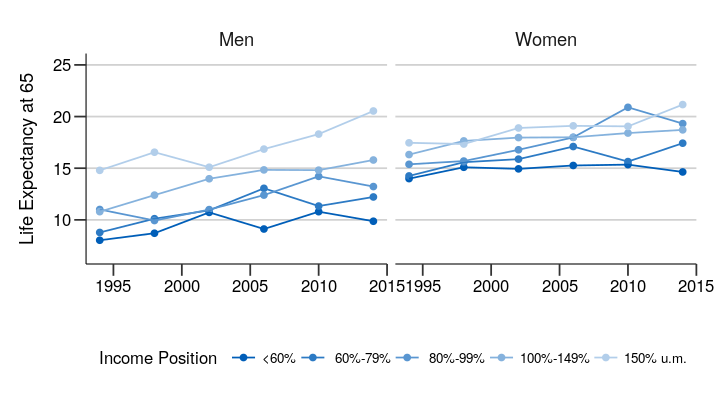

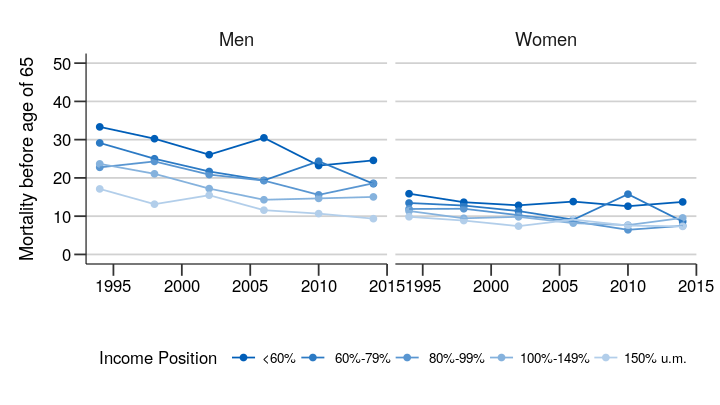

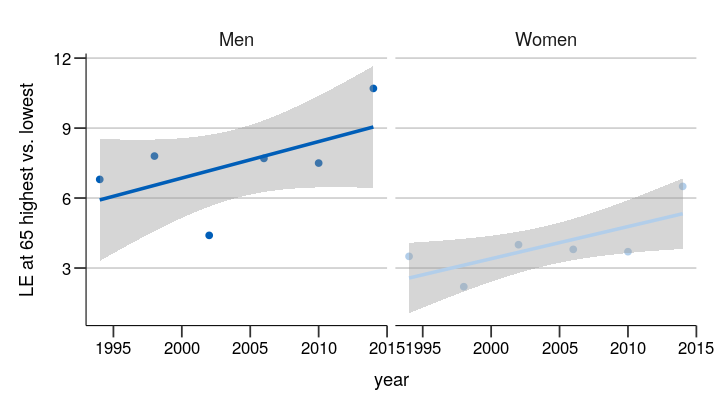

In [14]:
# Data
plotdata_at_65 <- plotdata %>% filter(age==65) %>% select(label,year=Jahr,sex=Geschlecht,LE_mean) %>% spread(label,LE_mean) %>% arrange(sex,year) %>%
left_join(.,anresult.le  %>% show_lediff(.,agefilter=65) %>% ungroup() %>% 
          mutate(year=round((begin+end)/2),
                 sex=ifelse(sex=="M","Men","Women"),
                 sex=ordered(sex,levels=c("Men","Women"))) )
wb <- loadWorkbook("Results_Mortality.xlsx")
addWorksheet(wb, "Plot LE at 65")
writeDataTable(wb, "Plot LE at 65", plotdata_at_65)
plotdata_at_65

# LE
trendplot <- ggplot(plotdata %>% filter(age==65), aes(x=Jahr, y=LE_mean, ymin=LE_min,ymax=LE_max, color=label)) + geom_point() + geom_line() +
facet_grid(.~ Geschlecht)   + theme_rki(base_size = 10) + scale_color_rki() +
labs(color="Income Position", x="" , y="Life Expectancy at 65") + theme(legend.pos="bottom") 
trendplot
insertPlot(wb, "Plot LE at 65", width = 7.11, height = 4, startRow = 1,  startCol = length(plotdata_at_birth)+3 , fileType = "png", units = "in", dpi = 400)

# Surv
trendplot_surv <- ggplot(plotdata %>% filter(age==65), aes(x=Jahr, y=100-Surv_mean, ymin=Surv_min,ymax=Surv_max, color=label)) + geom_point() + geom_line() +
facet_grid(.~ Geschlecht)   + theme_rki(base_size = 10) + scale_color_rki() +
labs(color="Income Position", x="" , y="Mortality before age of 65") + theme(legend.pos="bottom") +  coord_cartesian(ylim=c(0,50))
trendplot_surv
insertPlot(wb, "Plot LE at 65", width = 7.11, height = 4, startRow = 22,  startCol = 1 , fileType = "png", units = "in", dpi = 400)


# Difference
diffplot <- ggplot(plotdata_at_65 , aes(x=year , y=Diff, color=sex)) + geom_point() + theme_rki(base_size = 10) + scale_color_rki() +
facet_grid(.~ sex) + geom_smooth(method="gam")  + labs(y="LE at 65 highest vs. lowest")  + guides(color=FALSE)
diffplot
insertPlot(wb, "Plot LE at 65", width = 7.11, height = 4, startRow = 22,  startCol = length(plotdata_at_birth)+3 , fileType = "png", units = "in", dpi = 400)

# Excel Export
saveWorkbook(wb, "Results_Mortality.xlsx" , overwrite=TRUE)

In [15]:
sessionInfo()

R version 3.5.0 (2018-04-23)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 8 (jessie)

Matrix products: default
BLAS: /scratch/krolll/LK_R/lib/R/lib/libRblas.so
LAPACK: /scratch/krolll/LK_R/lib/R/lib/libRlapack.so

locale:
[1] en_US.UTF-8

attached base packages:
[1] parallel  grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] bindrcpp_0.2.2   openxlsx_4.1.0   doMC_1.3.5       iterators_1.0.10
 [5] foreach_1.5.0    survey_3.33-2    Matrix_1.2-14    srvyr_0.3.3     
 [9] ggfortify_0.4.5  wec_0.4-1        haven_1.1.1      rkicolors_0.1.0 
[13] survival_2.41-3  broom_0.4.4      forcats_0.3.0    stringr_1.3.1   
[17] dplyr_0.7.6      purrr_0.2.4      readr_1.1.1      tidyr_0.8.1     
[21] tibble_1.4.2     ggplot2_2.2.1    tidyverse_1.2.1 

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.18     lubridate_1.7.4  lattice_0.20-35  assertthat_0.2.0
 [5] digest_0.6.15    psych_1.8.4      IRdisplay_